## Explanation of Bubbles Concatenation
We have two bubbles templates from `1704.03910` and `1901.03822`. The latter is the inpainted version of the former. We would like the inpainted template, but it only exists for $r < 20^{\circ}$. Therefore, we want to use `1704.03910` to concatenate.

`Update`: This version uses the correct exposure correction determined by Yitian.

### Potential Issue: Do We Need To Inpaint for $r > 20^{\circ}$
No. As I show in Report 38, there is, at most, slight masking outside of $20^{\circ}$ that would require inpainting.
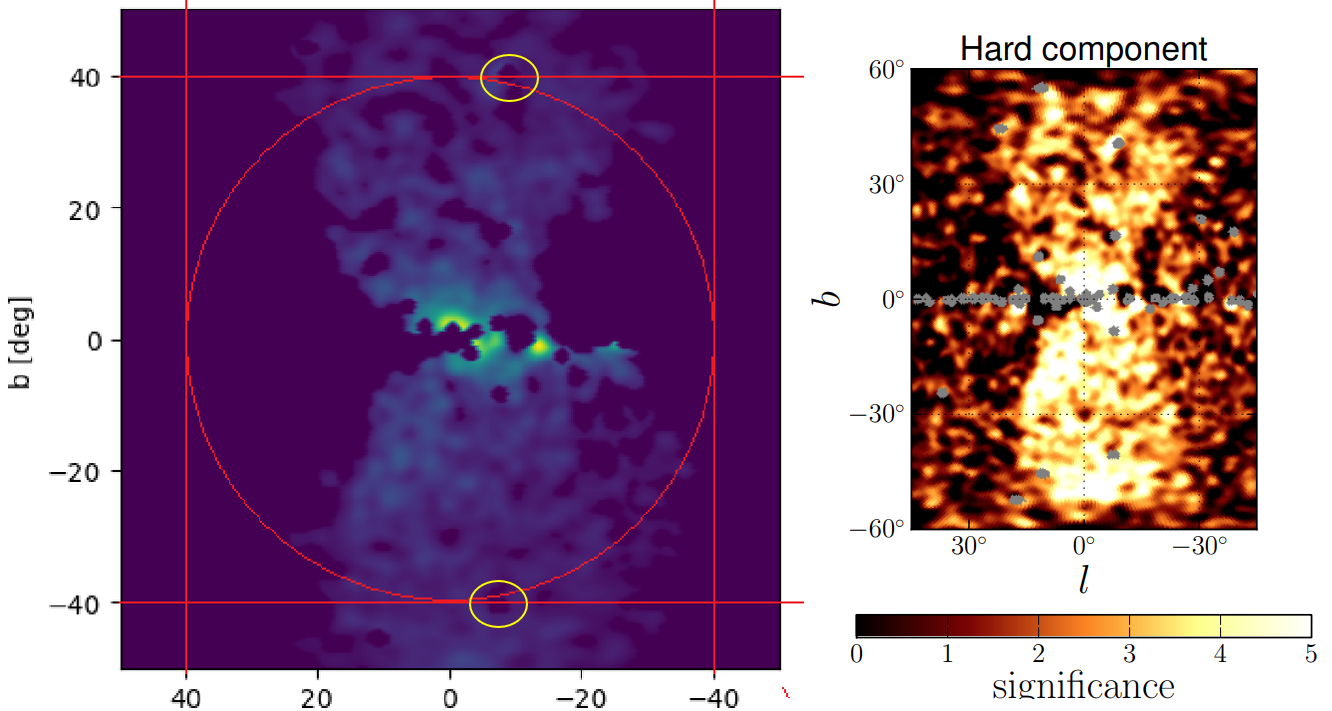

In [69]:
# Yitian block
%reload_ext autoreload
%autoreload 2

import os
import sys
sys.path.append("..")

import numpy as np
import healpy as hp

import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
import jax.scipy.optimize as optimize
from jax.scipy.stats.multivariate_normal import logpdf
from jax.example_libraries import stax

import optax
import numpyro
import numpyro.distributions as dist
from numpyro import optim
from numpyro.infer import SVI, Trace_ELBO, autoguide, TraceMeanField_ELBO
from numpyro.infer.elbo import Trace_ELBO_2
from numpyro.infer.reparam import NeuTraReparam
from numpyro.infer import MCMC, NUTS
from numpyro.contrib.tfp.mcmc import ReplicaExchangeMC
from tensorflow_probability.substrates import jax as tfp

from utils import create_mask as cm
from utils.sph_harm import Ylm
from utils.map_utils import to_nside
from utils import ed_fcts as ef
from utils import ed_plotting as eplt


from templates.rigid_templates import EbinTemplate, Template, BulgeTemplates
from templates.variable_templates import NFWTemplate, LorimerDiskTemplate
from likelihoods.pll_jax import log_like_poisson

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../utils/matplotlibrc')

import astropy.io
from astropy.io import fits
from utils.map_utils import to_nside

### Baseline: Simplest Concatenation
Here, we performed the simplest concatenation. We performed the concatenation around the square of length $20^\circ$. We renormalize the templates so that they have the same normalization in this square. 

In [98]:
# 06/24: Concatenating the 1704.03910 with the inpainted version from 1901.03822

data_dir = '../data/fermi_data_573w/fermi_data_256/'

# Load the data
bubbles_1 = np.load(data_dir + 'bubble_1901.03822_out_hp.npy')
bubbles_2 = np.load(data_dir + 'bubble_1704.03910_out_hp.npy')

In [99]:
nside = 128
npix = hp.nside2npix(nside)
print('NPIX for nside = {}: {}'.format(nside, npix))

print('Bubbles 1 shape: {}'.format(bubbles_1.shape))
print('Bubbles 2 shape: {}'.format(bubbles_2.shape))

NPIX for nside = 128: 196608
Bubbles 1 shape: (196608,)
Bubbles 2 shape: (196608,)


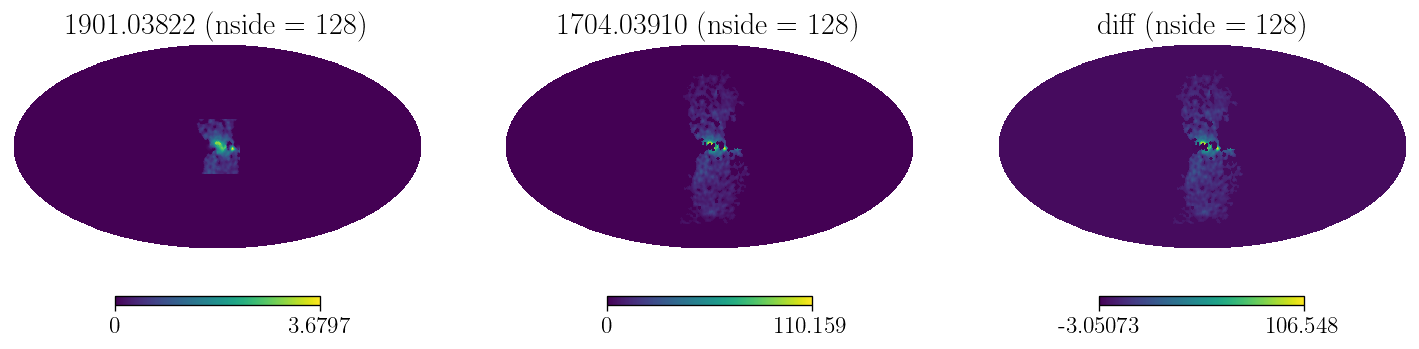

In [100]:
# compare the two maps, note differences in normalization
fig, ax_array = plt.subplots(figsize = (15,10), nrows = 1, ncols = 3)

ax1 = ax_array[0] ; ax2 = ax_array[1]; ax3 = ax_array[2]

plt.axes(ax1)
hp.mollview(bubbles_1, title="1901.03822 (nside = {})".format(nside), hold = True)

plt.axes(ax2)
hp.mollview(bubbles_2, title="1704.03910 (nside = {})".format(nside), hold = True)

plt.axes(ax3)
hp.mollview(bubbles_2 - bubbles_1, title="diff (nside = {})".format(nside), hold = True)

In [101]:
# set up mask for concatenation
nside = 128
npix = hp.nside2npix(nside)
mask_p = np.array([False for i in range(npix)], dtype = np.bool_)
x = ef.get_x_from_mask(mask_p, nside=nside)
mask = (np.linalg.norm(x, axis = -1, ord = np.inf) <= 19.)

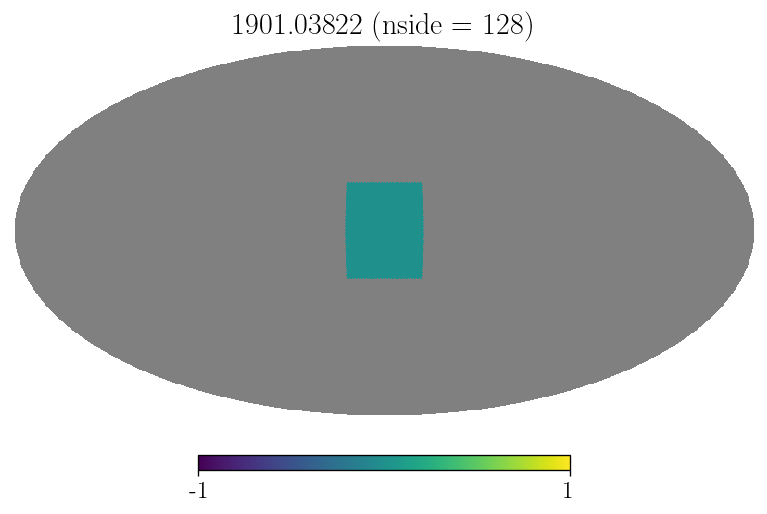

In [102]:
# check mask indeed makes a square
test_mask = ~mask
test_map = np.zeros(npix)[~test_mask]

fig, ax1 = plt.subplots(figsize = (8,8), nrows = 1, ncols = 1)
plt.axes(ax1)
test_map_hp = ef.convert_masked_array_to_hp_array(test_map, test_mask, log_option = False, nside = nside)
hp.mollview(test_map_hp, title="1901.03822 (nside = {})".format(nside), hold = True)

In [103]:
# impose normalizations to be the same in inner ROI
bubbles_1 /= np.sum(bubbles_1[mask])
bubbles_2 /= np.sum(bubbles_2[mask])
np.sum(bubbles_1[mask]), np.sum(bubbles_2[mask])

(0.9999999999999998, 1.0)

/tmp/ipykernel_3697929/2550245247.py:3: RuntimeWarning: divide by zero encountered in log10
  residual_map[mask] = np.log10(bubbles_2[mask]) - np.log10(bubbles_1[mask])
/tmp/ipykernel_3697929/2550245247.py:3: RuntimeWarning: invalid value encountered in subtract
  residual_map[mask] = np.log10(bubbles_2[mask]) - np.log10(bubbles_1[mask])


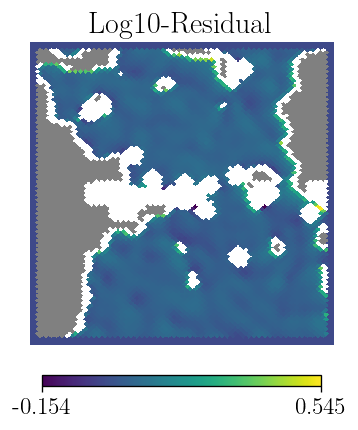

In [104]:
# check log-residuals
residual_map = np.zeros(npix)
residual_map[mask] = np.log10(bubbles_2[mask]) - np.log10(bubbles_1[mask]) 
hp.cartview(residual_map, lonra=[-20, 20], latra=[-20, 20], title='Log10-Residual', cbar=True, hold=True)

That's pretty good! Compare to masking that requires in-painting. 

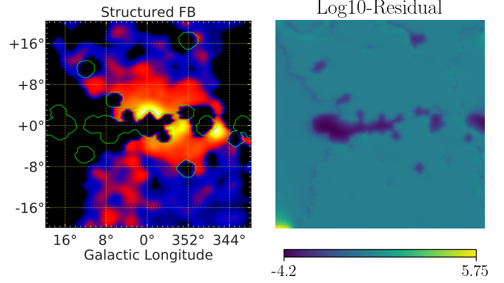

Let's concatenate the normalized maps now and see how it looks.

In [105]:
# concatenate maps
bubbles_3 = np.zeros(npix)
bubbles_3[mask] = bubbles_1[mask]
bubbles_3[~mask] = bubbles_2[~mask]

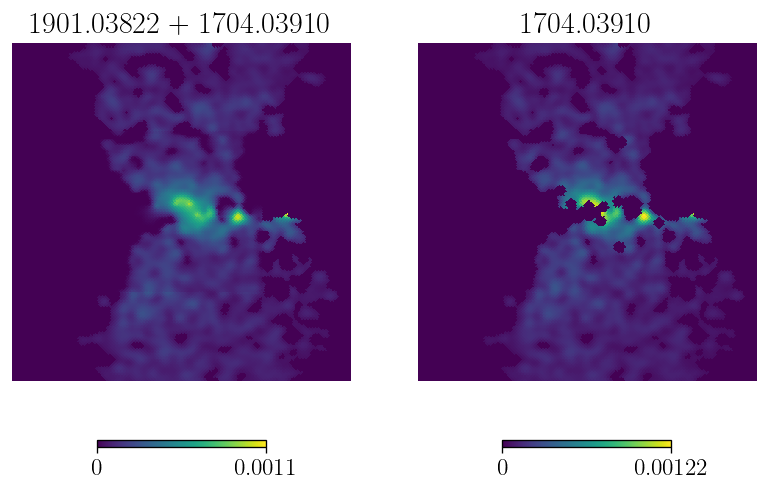

In [106]:
# two issues: artifact at the boundary of both maps
# and the normalization is off by quite a bit
fig, ax_array = plt.subplots(figsize = (8,8), nrows = 1, ncols = 2)
ax1 = ax_array[0] ; ax2 = ax_array[1]

plt.axes(ax1)
hp.cartview(bubbles_3, lonra=[-40, 40], latra=[-40, 40], title='1901.03822 + 1704.03910', cbar=True, hold=True)

plt.axes(ax2)
hp.cartview(bubbles_2, lonra=[-40, 40], latra=[-40, 40], title='1704.03910', cbar=True, hold=True)

### Improvement #1: Better Choice for Normalization
We renormalized the maps in a way that doesn't make a whole lot of sense. We don't expect these maps to have the same normalization within 20 deg since the inpainted map contains signal that is missing in the non-inpainted map. We improve this by normalizing both maps within the 40 deg square AND where the non-inpainted map has significant signal. 

What we call significant signal is now a hyperparameter. We choose it by eye by thresholding the non-inpainted map, ensuring that we are capturing the pixels that do not have missing signal. The thresholding will determine a new mask for normalization.

In [107]:
# Load the data
bubbles_1 = np.load(data_dir + 'bubble_1901.03822_out_hp.npy')
bubbles_2 = np.load(data_dir + 'bubble_1704.03910_out_hp.npy')

# set up mask for concatenation
nside = 128
npix = hp.nside2npix(nside)
mask_p = np.array([False for i in range(npix)], dtype = np.bool_)
x = ef.get_x_from_mask(mask_p, nside=nside)
mask = (np.linalg.norm(x, axis = -1, ord = np.inf) <= 19.)

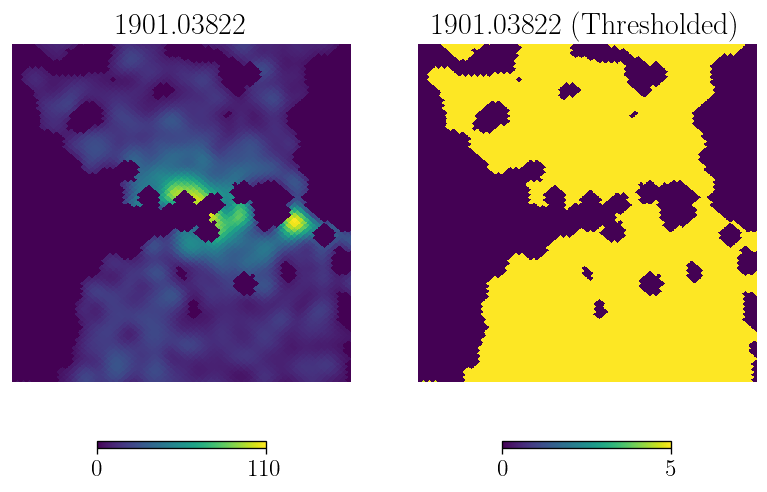

In [108]:
# thresholding by eye ; we take pixels with values > 10^(-7) for normalization
fig, ax_array = plt.subplots(figsize = (8,8), nrows = 1, ncols = 2)
ax1 = ax_array[0] ; ax2 = ax_array[1]

plt.axes(ax1)
hp.cartview(bubbles_2, lonra=[-20, 20], latra=[-20, 20], title='1901.03822', cbar=True, hold=True)

plt.axes(ax2)
hp.cartview(bubbles_2, lonra=[-20, 20], latra=[-20, 20], title='1901.03822 (Thresholded)', cbar=True, hold=True, max = 5)

In [109]:
# BETTER NORMALIZATION: Impose normalizations to be the same in regions where both maps have non-zero values
# NOTE: As we wanted, the inpainted map now has more signal than the non-inpainted map in the square
value_mask = (bubbles_2 > 5)
norm_mask = value_mask & mask

bubbles_1 /= np.sum(bubbles_1[norm_mask])
bubbles_2 /= np.sum(bubbles_2[norm_mask])
np.sum(bubbles_1[mask]), np.sum(bubbles_2[mask])

(1.1829182593639187, 1.000054857039761)

/tmp/ipykernel_3697929/2550245247.py:3: RuntimeWarning: divide by zero encountered in log10
  residual_map[mask] = np.log10(bubbles_2[mask]) - np.log10(bubbles_1[mask])
/tmp/ipykernel_3697929/2550245247.py:3: RuntimeWarning: invalid value encountered in subtract
  residual_map[mask] = np.log10(bubbles_2[mask]) - np.log10(bubbles_1[mask])


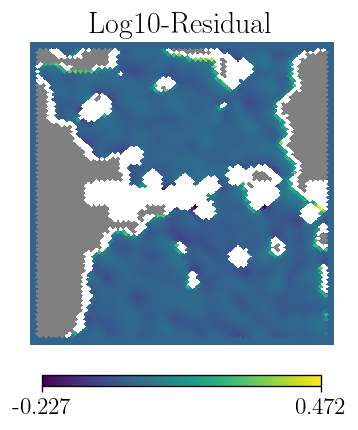

In [110]:
# check log-residuals
residual_map = np.zeros(npix)
residual_map[mask] = np.log10(bubbles_2[mask]) - np.log10(bubbles_1[mask]) 
hp.cartview(residual_map, lonra=[-20, 20], latra=[-20, 20], title='Log10-Residual', cbar=True, hold=True)

In [111]:
# concatenate maps
bubbles_3 = np.zeros(npix)
bubbles_3[mask] = bubbles_1[mask]
bubbles_3[~mask] = bubbles_2[~mask]

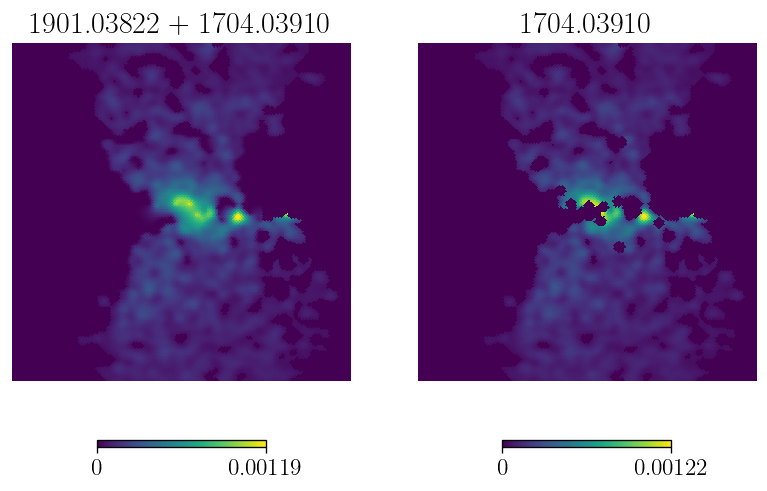

In [112]:
# notice that the normalization of both maps are now closer
fig, ax_array = plt.subplots(figsize = (8,8), nrows = 1, ncols = 2)
ax1 = ax_array[0] ; ax2 = ax_array[1]

plt.axes(ax1)
hp.cartview(bubbles_3, lonra=[-40, 40], latra=[-40, 40], title='1901.03822 + 1704.03910', cbar=True, hold=True)

plt.axes(ax2)
hp.cartview(bubbles_2, lonra=[-40, 40], latra=[-40, 40], title='1704.03910', cbar=True, hold=True)

### Improvement #2: Alleviate Discontinuity at Concatenation Boundary
This may be due in part to rebinning of the inpainted map at its boundary. To alleviate this effect, we shrink the mask as much as possible, ensuring that we don't remove the inpainting occurring around $b = 16^{\circ}$. 

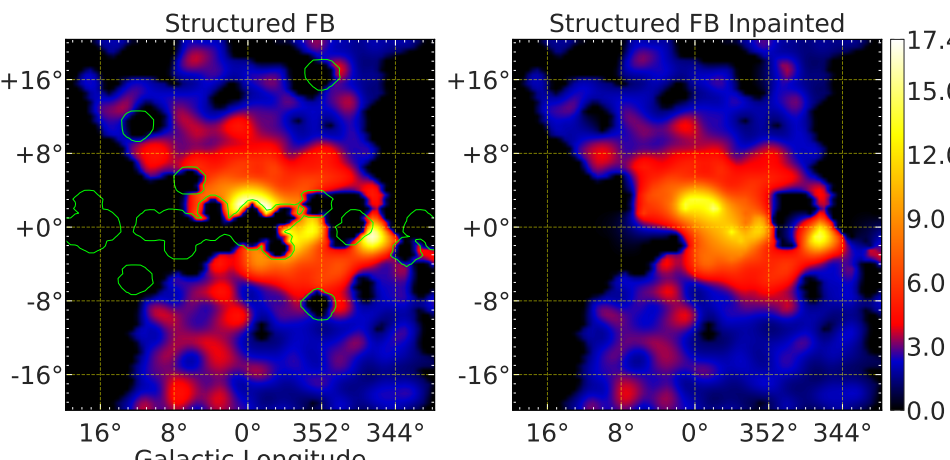

In [113]:
# proceed as before

# Load the data
bubbles_1 = np.load(data_dir + 'bubble_1901.03822_out_hp.npy')
bubbles_2 = np.load(data_dir + 'bubble_1704.03910_out_hp.npy')

# set up mask for concatenation
nside = 128
npix = hp.nside2npix(nside)
mask_p = np.array([False for i in range(npix)], dtype = np.bool_)
x = ef.get_x_from_mask(mask_p, nside=nside)
mask = (np.linalg.norm(x, axis = -1, ord = np.inf) <= 18.) # NOTICE THAT WE SHRINK THE CONCATENATION SQUARE

In [114]:
# BETTER NORMALIZATION: Impose normalizations to be the same in regions where both maps have non-zero values
# NOTE: As we wanted, the inpainted map now has more signal than the non-inpainted map in the square
value_mask = (bubbles_2 > 5.)
norm_mask = value_mask & mask

bubbles_1 /= np.sum(bubbles_1[norm_mask])
bubbles_2 /= np.sum(bubbles_2[norm_mask])
np.sum(bubbles_1[mask]), np.sum(bubbles_2[mask])

(1.1880005394585187, 1.0)

/tmp/ipykernel_3697929/2550245247.py:3: RuntimeWarning: divide by zero encountered in log10
  residual_map[mask] = np.log10(bubbles_2[mask]) - np.log10(bubbles_1[mask])
/tmp/ipykernel_3697929/2550245247.py:3: RuntimeWarning: invalid value encountered in subtract
  residual_map[mask] = np.log10(bubbles_2[mask]) - np.log10(bubbles_1[mask])


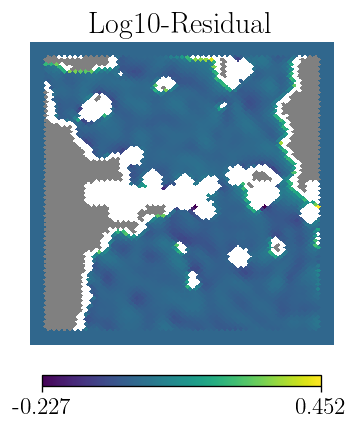

In [115]:
# check log-residuals
residual_map = np.zeros(npix)
residual_map[mask] = np.log10(bubbles_2[mask]) - np.log10(bubbles_1[mask]) 
hp.cartview(residual_map, lonra=[-20, 20], latra=[-20, 20], title='Log10-Residual', cbar=True, hold=True)

In [116]:
# concatenate maps
bubbles_3 = np.zeros(npix)
bubbles_3[mask] = bubbles_1[mask]
bubbles_3[~mask] = bubbles_2[~mask]

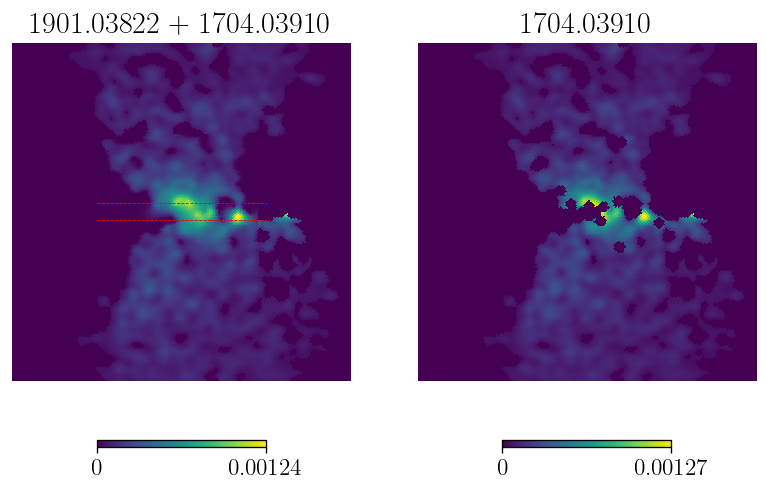

In [117]:
# notice the artifact is less noticable
# UPDATE: artifact to the right near the disk from inpainting. However, mask covers most of it.
fig, ax_array = plt.subplots(figsize = (8,8), nrows = 1, ncols = 2)
ax1 = ax_array[0] ; ax2 = ax_array[1]

plt.axes(ax1)
hp.cartview(bubbles_3, lonra=[-40, 40], latra=[-40, 40], title='1901.03822 + 1704.03910', cbar=True, hold=True)
plt.plot([-20, 20], [-2, -2] , 'r--', lw = 0.5)
plt.plot([-20, 20], [2, 2] , 'r--', lw = 0.5)

plt.axes(ax2)
hp.cartview(bubbles_2, lonra=[-40, 40], latra=[-40, 40], title='1704.03910', cbar=True, hold=True)

In [118]:
np.save(data_dir + 'bubble_concat_out_hp.npy', bubbles_3)

In [119]:
bubbles_3_load = np.load(data_dir + 'bubble_concat_out_hp.npy')
bubbles_3_load == bubbles_3

array([ True,  True,  True, ...,  True,  True,  True])

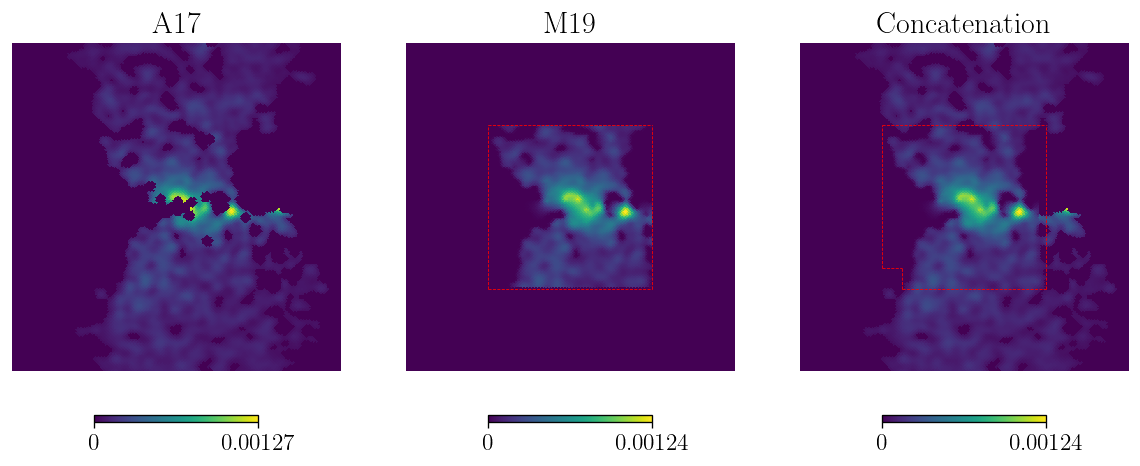

In [120]:
# two issues: artifact at the boundary of both maps
# and the normalization is off by quite a bit

fig, ax_array = plt.subplots(figsize = (12,6), nrows = 1, ncols = 3)
ax1 = ax_array[0] ; ax2 = ax_array[1] ; ax3 = ax_array[2]

plt.axes(ax1)
b2 = hp.cartview(bubbles_2, lonra=[-40, 40], latra=[-40, 40], title='A17', cbar=True, hold=True)

plt.axes(ax2)
hp.cartview(bubbles_1, lonra=[-40, 40], latra=[-40, 40], title='M19', cbar=True, hold=True)
plt.plot([-20, 20], [-20, -20] , 'r--', lw = 0.5)
plt.plot([-20, 20], [20, 20] , 'r--', lw = 0.5)
plt.plot([-20, -20], [-20, 20] , 'r--', lw = 0.5)
plt.plot([20, 20], [-20, 20] , 'r--', lw = 0.5)

plt.axes(ax3)
hp.cartview(bubbles_3, lonra=[-40, 40], latra=[-40, 40], title='Concatenation', cbar=True, hold=True)
plt.plot([-20, 20], [20, 20] , 'r--', lw = 0.5)
plt.plot([-20, -20], [-15, 20] , 'r--', lw = 0.5)
plt.plot([-15, 20], [-20, -20] , 'r--', lw = 0.5)
plt.plot([-15, -15], [-20, -15] , 'r--', lw = 0.5)
plt.plot([-20, -15], [-15, -15] , 'r--', lw = 0.5)
plt.plot([20, 20], [-20, 20] , 'r--', lw = 0.5)

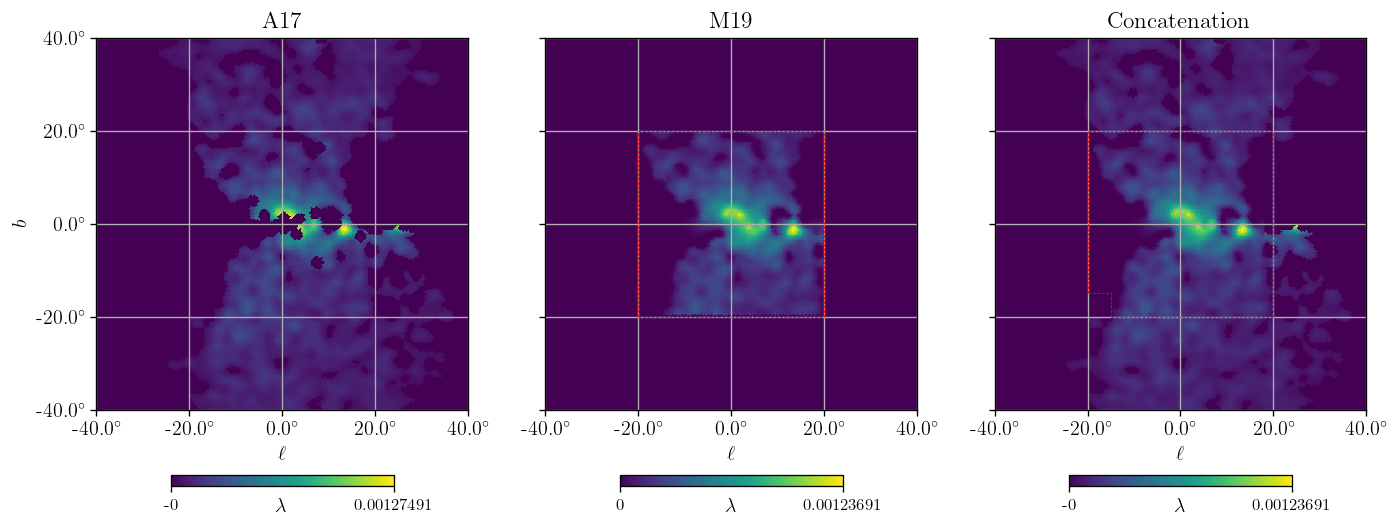

In [121]:
# two issues: artifact at the boundary of both maps
# and the normalization is off by quite a bit

fig, ax_array = plt.subplots(figsize = (12,6), nrows = 1, ncols = 3)
ax1 = ax_array[0] ; ax2 = ax_array[1] ; ax3 = ax_array[2]

plt.axes(ax1)
m = bubbles_2
eplt.bub_map(m, title = 'A17', subplot = 131)
plt.xlim(np.deg2rad(-40),np.deg2rad(40))
plt.ylim(np.deg2rad(-40),np.deg2rad(40))
plt.grid(None)

plt.axes(ax2)
m = bubbles_1
eplt.bub_map(m, title = 'M19', subplot = 132, display_y_info = False)
plt.xlim(np.deg2rad(-40),np.deg2rad(40))
plt.ylim(np.deg2rad(-40),np.deg2rad(40))
plt.grid(None)

# add the boundary of template
plt.plot([-np.deg2rad(20), np.deg2rad(20)], [-np.deg2rad(20), -np.deg2rad(20)] , 'r--', lw = 0.5)
plt.plot([-np.deg2rad(20), np.deg2rad(20)], [np.deg2rad(20), np.deg2rad(20)] , 'r--', lw = 0.5)
plt.plot([-np.deg2rad(20), -np.deg2rad(20)], [-np.deg2rad(20), np.deg2rad(20)] , 'r--', lw = 0.5)
plt.plot([np.deg2rad(20), np.deg2rad(20)], [-np.deg2rad(20), np.deg2rad(20)] , 'r--', lw = 0.5)

plt.axes(ax3)
m = bubbles_3
eplt.bub_map(m, title = 'Concatenation', subplot = 133, display_y_info = False)
plt.xlim(np.deg2rad(-40),np.deg2rad(40))
plt.ylim(np.deg2rad(-40),np.deg2rad(40))
plt.grid(None)

# add the concatenation boundary
plt.plot([-np.deg2rad(20), np.deg2rad(20)], [np.deg2rad(20), np.deg2rad(20)] , 'r--', lw = 0.5)
plt.plot([-np.deg2rad(20), -np.deg2rad(20)], [-np.deg2rad(15), np.deg2rad(20)] , 'r--', lw = 0.5)
plt.plot([-np.deg2rad(15), np.deg2rad(20)], [-np.deg2rad(20), -np.deg2rad(20)] , 'r--', lw = 0.5)
plt.plot([-np.deg2rad(15), -np.deg2rad(15)], [-np.deg2rad(20), -np.deg2rad(15)] , 'r--', lw = 0.5)
plt.plot([-np.deg2rad(20), -np.deg2rad(15)], [-np.deg2rad(15), -np.deg2rad(15)] , 'r--', lw = 0.5)
plt.plot([np.deg2rad(20), np.deg2rad(20)], [-np.deg2rad(20), np.deg2rad(20)] , 'r--', lw = 0.5)

plt.tight_layout()

In [122]:
import pickle
pickle.dump(
    [bubbles_1, bubbles_2, bubbles_3],
    open('../figures/data/app_bubbles.p', 'wb')
)

In [123]:
bubbles_3.shape

(196608,)

In [131]:
from utils.map_utils import to_nside
bubbles_3_test = to_nside(bubbles_3, 128)

In [132]:
np.where(bubbles_3_test != bubbles_3)

(array([], dtype=int64),)